### Confidence Interval and Statistical Significance

*(Coding along with the Udemy Couse [Python for Business and Finance](https://www.udemy.com/course/complete-python-for-business-and-finance-bootcamp/) by Alexander Hagmann.)*

The correlation we've calculated (see previous notebook) is only a point estimate which doesn't really allow to draw a conclusion about the relationship between budget and revenue without a statistical test of significance or without creating a confidence interval estimate.

#### <span style="color: green; line-height: 1.5">Claude.ai, if I've calculated a correlation coefficient, why do I need a statistical test of significance or a confidence interval estimate to draw a conclusion between the relationship of two variables?</span>

> The correlation coefficient (r) shows the strength and direction of a linear relationship between two variables, but it doesn't tell you whether this relationship is statistically meaningful or could have occurred by chance.
>
> A statistical test of significance (like a t-test for correlation) helps you determine if the observed correlation is likely to be different from zero in the population, not just a random occurrence in your sample. The p-value from this test indicates the probability of observing such a correlation if no true relationship exists.
> 
> __A confidence interval provides additional context by giving you a range of plausible values for the true population correlation, along with a specified level of confidence (typically 95%). This helps you understand the precision of your estimate and whether the correlation could include zero (which would suggest no meaningful relationship).__
>
> In essence, the correlation coefficient describes the relationship, while significance testing and confidence intervals help you assess whether that relationship is reliable and meaningful beyond random chance.

### Creating a Confidence Interval Estimate with Bootstrapping

#### <span style="color: green; line-height: 1.5">Claude.ai, what does it mean to create a confidence interval estimate with bootstrapping? What exactly is bootstrapping here?</span>

> Bootstrapping is a resampling technique used to estimate the sampling distribution of a statistic (like a correlation coefficient) when the underlying population distribution is unknown. 
> 
> Here's how it works:
> 1. Take your original sample data
> 2. Randomly resample the data with replacement many times (typically 1000-10000 times)
> 3. Calculate the statistic of interest (e.g., correlation) for each resampled dataset
> 4. Create a distribution of these calculated statistics
> 5. Use this distribution to construct a confidence interval
> 
> For a confidence interval, you'd typically take the values at the 2.5th and 97.5th percentiles of this bootstrapped distribution to create a 95% confidence interval. This approach allows you to estimate the uncertainty around your statistic without making assumptions about the underlying population distribution, making it particularly useful when traditional parametric methods might not be appropriate.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
np.set_printoptions(precision=2, suppress= True)

In [71]:
# importing our data and setting release_date as the datetime index
df = pd.read_csv("../assets/data/bud_vs_rev.csv", parse_dates = ["release_date"], index_col = "release_date")

In [72]:
df

,title,budget,revenue
release_date,,,
1915-02-08,The Birth of a Nation,0.100000,11.000000
1915-12-13,The Cheat,0.017311,0.137365
1916-12-24,"20,000 Leagues Under the Sea",0.200000,8.000000
1918-08-01,Mickey,0.250000,8.000000
1921-01-21,The Kid,0.250000,2.500000
...,...,...,...
2017-07-26,Atomic Blonde,30.000000,90.007945
2017-07-28,The Emoji Movie,50.000000,66.913939
2017-08-03,The Dark Tower,60.000000,71.000000


In [73]:
# focusing on more recent data
df = df.loc["2016"] # cutting out the 2016 release dates and overwriting the dataframe

In [74]:
df

,title,budget,revenue
release_date,,,
2016-01-01,Jane Got a Gun,25.0,1.397284
2016-01-07,Friend Request,9.9,2.400000
2016-01-07,The Forest,10.0,40.055439
2016-01-07,Wazir,5.2,9.200000
2016-01-13,13 Hours: The Secret Soldiers of Benghazi,50.0,69.411370
...,...,...,...
2016-12-23,Resident Evil: The Final Chapter,40.0,312.242626
2016-12-23,Railroad Tigers,50.0,102.205175
2016-12-23,Dangal,10.4,310.000000


In [75]:
# converting dataframe to numpy array
# using only the last two columns with iloc[:, -2:]
array = df.iloc[:, -2:].values
# we get array with 2 columns, first is budget, 2nd is revenue
array[:10] # showing first ten rows only

array([[ 25.  ,   1.4 ],
       [  9.9 ,   2.4 ],
       [ 10.  ,  40.06],
       [  5.2 ,   9.2 ],
       [ 50.  ,  69.41],
       [ 18.  ,  17.06],
       [ 40.  , 124.83],
       [ 38.  , 109.91],
       [ 11.5 ,  94.07],
       [ 38.  , 112.34]])

In [76]:
array.shape # we've 235 rows

(235, 2)

In [77]:
# calculating the correlation coefficient
# we need to pass the transposed array
np.corrcoef(array.T) # creates correlation matrix

array([[1. , 0.8],
       [0.8, 1. ]])

In [78]:
# calculating the correlation coefficient
# we need to pass the transposed array
np.corrcoef(array.T)[0, 1] # correlation between the two variables

np.float64(0.8001327462030162)

In [79]:
size = array.shape[0] # saving the number of observations
size

235

#### __One Bootstrap Sample__

Let's start with __one bootstrap sample__. One bootstrap sample consists of 235 observations that can be extracted from out data. We randomly select 235 movies from our data with replacements. This means some movies might appear two or three times or even more often in our sample.

In [80]:
np.random.seed(123) # setting a random seed to 123
# first creating index positions from 0 to 234 (235 exclusive, 235=size)
# index positions will get selected with replacements so we'll have duplicates
indxs = np.random.randint(low = 0, high = size, size = size)

In [81]:
indxs

array([109, 126,  66, 220,  98, 230,  17,  83, 106, 123,  57, 214, 225,
        96, 113, 126,  47,  73,  32, 174, 224, 111, 153,  83,  78, 164,
        96, 208,  68,  49,  55, 195,   2,  84,  39,  66,  84,  47, 189,
       176, 135, 105,  99, 124,  92, 180, 102,  97, 213, 118,  94, 155,
        34, 225,  76, 168, 131, 106,  69,  64,  75, 162,  58, 138,  22,
       205, 146, 228,  15, 155, 158, 180,  70, 109, 115, 154, 208, 134,
        14, 103, 203, 182, 199, 129,  43, 186, 101, 183,  25, 178, 212,
        56,  49,  12,  18, 209,   1,  51, 172, 117, 233,  48,  56, 219,
       177,  86,   3,  67, 139, 149, 217, 103, 233,  98,   3, 139,   3,
       222,   6,   9,  87,  14, 230, 211, 121, 198, 140, 182,  27,  38,
       145, 189, 110,  74,  99, 116,  99, 193,  47,  16, 133, 104, 109,
        86,  46,  15,  59,  40, 153,  45, 177,   0, 163, 157, 129, 211,
        68, 158, 135,  93, 230,  60,  65, 116, 204,  67,  44,  51, 135,
       230,  88, 198, 141, 156, 108,  63,  84, 164, 119, 224, 12

In [82]:
# now we're indexing our numpy array
array[indxs]

array([[ 180.  ,  356.74],
       [  18.7 ,   74.  ],
       [  20.  ,   55.03],
       [  30.  ,    2.35],
       [ 200.  , 1028.57],
       [  40.  ,  312.24],
       [   0.  ,    0.  ],
       [ 178.  ,  543.93],
       [   0.52,    1.01],
       [   3.5 ,    3.77],
       [   3.2 ,    4.27],
       [  30.  ,  445.44],
       [ 110.  ,  303.14],
       [   3.5 ,    1.49],
       [  33.  ,   77.07],
       [  18.7 ,   74.  ],
       [  15.  ,  108.29],
       [  16.5 ,    0.02],
       [  20.  ,   46.07],
       [ 125.  ,  346.86],
       [ 125.  ,   64.49],
       [   5.  ,    5.88],
       [  90.  ,  162.36],
       [ 178.  ,  543.93],
       [  73.  ,  349.78],
       [   7.5 ,    9.1 ],
       [   3.5 ,    1.49],
       [   4.3 ,    3.38],
       [  15.  ,   20.57],
       [   4.  ,   13.62],
       [  10.  ,    3.4 ],
       [  17.  ,   42.49],
       [  10.  ,   40.06],
       [   2.  ,    0.34],
       [  23.  ,   46.15],
       [  20.  ,   55.03],
       [   2.  ,    0.34],
 

In [83]:
# calculating the correlation coefficient for the bootstrapped array
# once again with a transpose of the array first
np.corrcoef(array[indxs].T)[0, 1]

np.float64(0.7981448204332644)

In [84]:
sims = 100000

#### __Many Bootstrap Samples__

Repating the whole process 100.000 times with 100.000 simulations.

In [85]:
np.random.seed(123)
# once again filling an index with random numbers 0 zero and 234 (included)
# this time size * sims (235 * 100.000)
# then we reshape it to a matrix with 100.000 rows and 235 columns
indxs = np.random.randint(low = 0, high = size, size = size * sims).reshape(sims, size)

In [86]:
indxs.shape

(100000, 235)

In [87]:
indxs

array([[109, 126,  66, ..., 195, 139, 154],
       [ 92, 203, 138, ..., 233, 219,  79],
       [112, 106, 219, ..., 130, 149,  84],
       ...,
       [ 19, 223,   3, ..., 141, 119,  27],
       [ 17, 169,  87, ..., 223, 193, 150],
       [193, 165, 230, ..., 133, 110, 163]])

In [88]:
for i in range(2):
    print(array[indxs[i]])

[[ 180.    356.74]
 [  18.7    74.  ]
 [  20.     55.03]
 [  30.      2.35]
 [ 200.   1028.57]
 [  40.    312.24]
 [   0.      0.  ]
 [ 178.    543.93]
 [   0.52    1.01]
 [   3.5     3.77]
 [   3.2     4.27]
 [  30.    445.44]
 [ 110.    303.14]
 [   3.5     1.49]
 [  33.     77.07]
 [  18.7    74.  ]
 [  15.    108.29]
 [  16.5     0.02]
 [  20.     46.07]
 [ 125.    346.86]
 [ 125.     64.49]
 [   5.      5.88]
 [  90.    162.36]
 [ 178.    543.93]
 [  73.    349.78]
 [   7.5     9.1 ]
 [   3.5     1.49]
 [   4.3     3.38]
 [  15.     20.57]
 [   4.     13.62]
 [  10.      3.4 ]
 [  17.     42.49]
 [  10.     40.06]
 [   2.      0.34]
 [  23.     46.15]
 [  20.     55.03]
 [   2.      0.34]
 [  15.    108.29]
 [   8.      0.08]
 [  10.      6.27]
 [  65.    143.7 ]
 [  10.      0.  ]
 [   5.98   14.9 ]
 [   4.9   148.87]
 [  20.    207.95]
 [  60.    162.15]
 [ 105.    408.58]
 [  50.    216.97]
 [  35.     81.09]
 [  25.     15.44]
 [   7.      1.33]
 [   5.     45.17]
 [  20.     

In [89]:
# for each of the 100.000 arrays (our rows) in index we're creating our bootstrap sample with array[indxs[i]]
# then we're calculating the correlation coefficient for each bootstrapped array
corr = [] # list to store all correlation coefficients
for i in range(sims):
    corr.append(np.corrcoef(array[indxs[i]].T)[0, 1])

In [90]:
corr[:20] # showing first 20 only

[np.float64(0.7981448204332644),
 np.float64(0.8191044990560746),
 np.float64(0.8237491882953752),
 np.float64(0.7714744355222747),
 np.float64(0.7646349094333265),
 np.float64(0.7458451512909035),
 np.float64(0.7949066424345488),
 np.float64(0.7774860985514475),
 np.float64(0.7870927128777789),
 np.float64(0.762423137843418),
 np.float64(0.8027592932895116),
 np.float64(0.7317052227235344),
 np.float64(0.7911832825191357),
 np.float64(0.859937865428973),
 np.float64(0.8050415397815204),
 np.float64(0.7693562131102887),
 np.float64(0.7798866358760902),
 np.float64(0.7883171129185053),
 np.float64(0.8110164433562935),
 np.float64(0.7624187786892056)]

In [91]:
len(corr)

100000

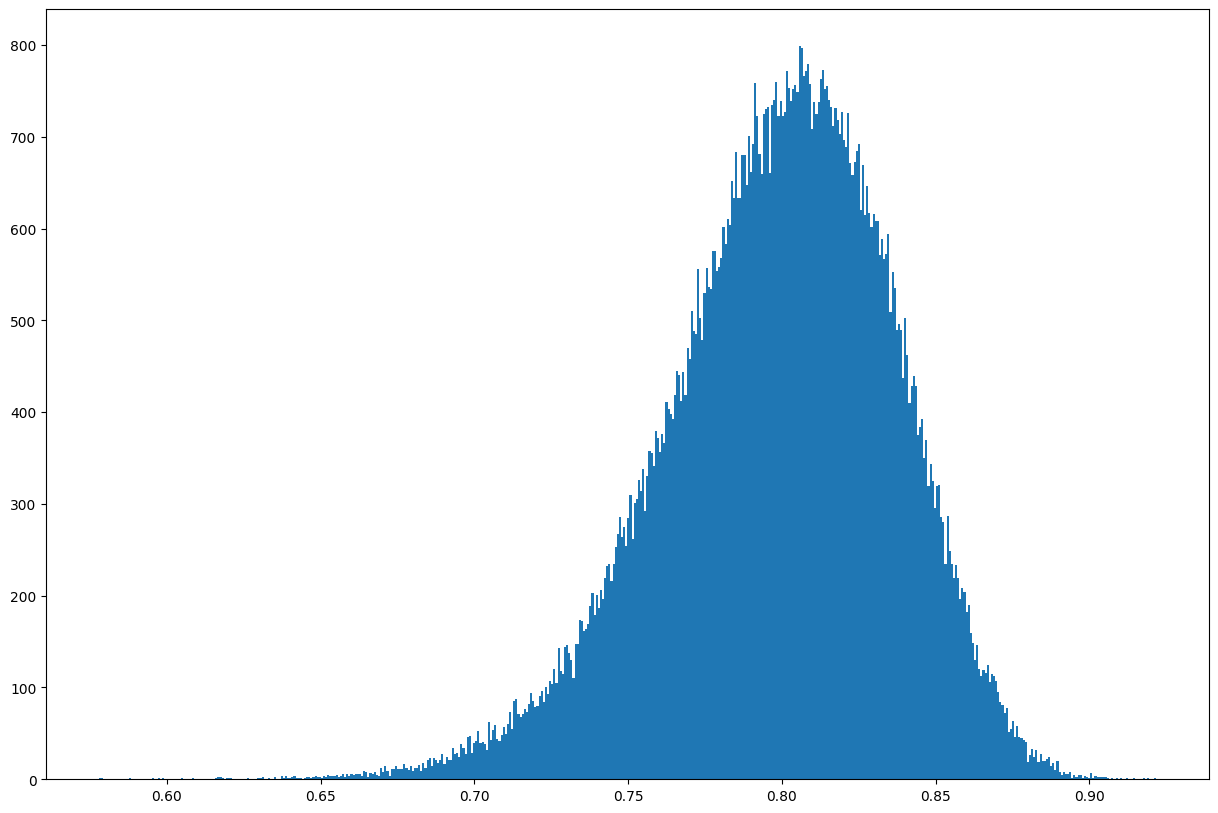

In [92]:
# visualizing the bootstapped correlations // visualizing the distribution
plt.figure(figsize = (15, 10))
plt.hist(corr, bins = 500)
plt.show()

In [93]:
np.min(corr) # minimum correlation coefficient of the 100.000 bootstrap samples

np.float64(0.5778957658085604)

#### __95% Confidence Interval Estimate__

Creating the 95% confidence interval estimate with np.percentile(), passing in the list of coefficients and a confidence intervall that goes from the 2.5th percentile to the 97.5th percentile.

In [94]:
np.percentile(corr, [2.5, 97.5])

array([0.72, 0.86])

***The result is an array with the values [0.72, 0.86], which means we can be 95% confident that the true correlation coefficient between budget and revenue is between 0.72 and 0.86. So we're having a clearly positive relationship.***

### Testing for Correlation (t-Test)

We're going to perform a hypothesis test to verify wether there is a significant correlation between budget and revenue. The test we're going to perform is a __t-test__ where we have a __null-Hypothesis H0__ that assumes that the correlation is equal to zero and an __alternative Hypothesis H1__ which assumes that the correlation is unequal to zero (meaning that there is a significant relationship between budget and revenue). In order to draw the conclusion that the alternative Hypothesis H1 is correct, we have to reject the null-Hypothesis H0.

Calculate the __Correlation Coefficient__ (r) between __Movie Budgets__ and __Movie Revenues__ (for Movies released in 2016) and __test on a 5% significance level__, whether there is a linear relationship (H0: r == 0). 

Given the assumption that there's no relationship, the t-test indicates the propability that we get a correlation coefficient at least as extreme as the one in our sample with 235 movies. This propability is the so called __p-value__. A very low p-value leads to the rejection of the null-hypothesis and the conclusion that there is a significant linear relationship.

In [95]:
df # still the same dataframe

,title,budget,revenue
release_date,,,
2016-01-01,Jane Got a Gun,25.0,1.397284
2016-01-07,Friend Request,9.9,2.400000
2016-01-07,The Forest,10.0,40.055439
2016-01-07,Wazir,5.2,9.200000
2016-01-13,13 Hours: The Secret Soldiers of Benghazi,50.0,69.411370
...,...,...,...
2016-12-23,Resident Evil: The Final Chapter,40.0,312.242626
2016-12-23,Railroad Tigers,50.0,102.205175
2016-12-23,Dangal,10.4,310.000000


__H0: r == 0__ <br>
__Ha: r != 0__

#### __scipy.stats.pearsonr: Pearson correlation coefficient and p-value for testing non-correlation.__

The Pearson correlation coefficient measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

This function also performs a ***test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed***. The ***p-value roughly indicates the probability of an uncorrelated system producing datasets** that have a Pearson correlation at least as extreme as the one computed from these datasets (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html).

In [96]:
# working with the pearson correlation coefficient from scipy.stats
r, p_value = stats.pearsonr(df.budget, df.revenue)

In [97]:
r 

np.float64(0.8001327462030163)

In [98]:
p_value # very low; close to zero

np.float64(1.238743107524095e-53)

***Interpretaion: given the assumption that the correlation is zero (H0), it is almost zero percent likely (p-value) the this assumption is true and we therefore can reject the zero-Hypothesis and conclude that there is a significant relationship.***